## Part 2: Clinical Application

### Contents
Fill out this notebook as part 2 of your final project submission.

**You will have to complete the Code (Load Metadata & Compute Resting Heart Rate) and Project Write-up sections.**  

- [Code](#Code) is where you will implement some parts of the **pulse rate algorithm** you created and tested in Part 1 and already includes the starter code.
  - [Imports](#Imports) - These are the imports needed for Part 2 of the final project. 
    - [glob](https://docs.python.org/3/library/glob.html)
    - [os](https://docs.python.org/3/library/os.html)
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
  - [Load the Dataset](#Load-the-dataset)  
  - [Load Metadata](#Load-Metadata)
  - [Compute Resting Heart Rate](#Compute-Resting-Heart-Rate)
  - [Plot Resting Heart Rate vs. Age Group](#Plot-Resting-Heart-Rate-vs.-Age-Group)
- [Project Write-up](#Project-Write-Up) to describe the clinical significance you observe from the **pulse rate algorithm** applied to this dataset, what ways/information that could improve your results, and if we validated a trend known in the science community. 

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.[1] This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.[2]

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

### Code
#### Imports

When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages are imported for you here. We recommend you don't import other packages outside of the [Standard Library](https://docs.python.org/3/library/) , otherwise the grader might not be able to run your code.

In [1]:
import sys 
!{sys.executable} -m pip install seaborn==0.9.0

    100% |████████████████████████████████| 215kB 8.1MB/s ta 0:00:01
  Found existing installation: seaborn 0.8.1
    Uninstalling seaborn-0.8.1:
      Successfully uninstalled seaborn-0.8.1


In [2]:
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

In [3]:
hr_filenames = glob.glob('/data/crisdb/*.npz')

In [4]:
hr_filenames[0]

'/data/crisdb/e190a.npz'

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [5]:
metadata_filename = '/data/crisdb/metadata.csv'

# Load the metadata file into this variable.
with open(metadata_filename, 'r') as f:
    metadata = pd.read_csv(metadata_filename)

In [6]:
metadata.head()

,subject,age,sex
0,e198a,20-24,Male
1,e198b,20-24,Male
2,e028b,30-34,Male
3,e028a,30-34,Male
4,e061b,30-34,Male


#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [7]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)

    # Find the subject ID from the filename.
    subject = filename.split('/')[-1].split('.')[0]

    # Find the age group for this subject in metadata.
    age_group = metadata[metadata['subject']==subject]['age'].values[0]
    
    # Find the sex for this subject in metadata.
    sex = metadata[metadata['subject']==subject]['sex'].values[0]

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])

In [8]:
df.head()

,age_group,sex,rhr
0,60-64,Female,89.302326
1,65-69,Male,65.641026
2,45-49,Male,56.928458
3,60-64,Male,68.571429
4,50-54,Male,84.395604


### Test, EDA, and others...

In [10]:
hr_data_test = np.load(hr_filenames[0])['hr']

In [11]:
hr_data_test.shape

(86212,)

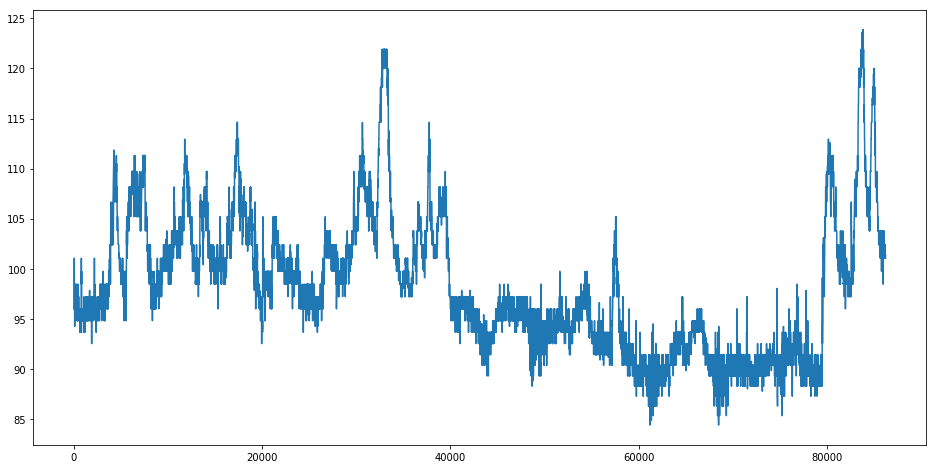

In [12]:
#plot 
plt.figure(figsize=(16,8))
plt.plot(hr_data_test)

#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib, which we've used extensively in this class, that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. Learn more about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

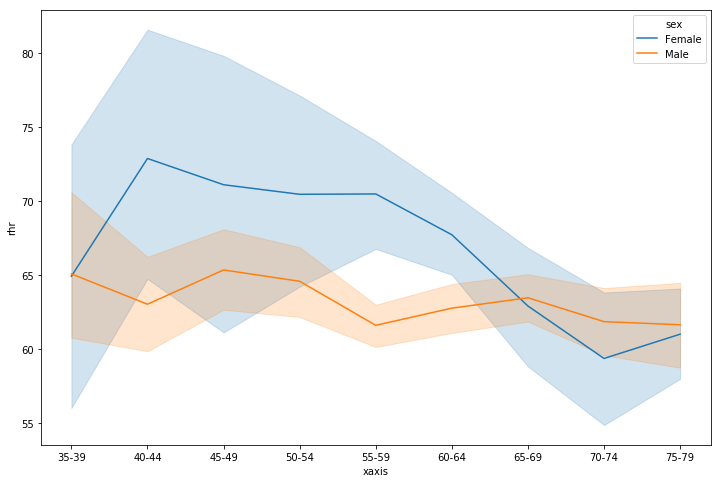

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df)
_ = plt.xticks(np.arange(len(labels)), labels)

### Clinical Conclusion
Answer the following prompts to draw a conclusion about the data.
> **1. For women, we see...** that there is an upward trend in heart rate from age 35 until ~40 that starts to decrease progresivelly as women come to age. What is interesting is that there is a small spike towards the latter years (79+). Also, its remarkable the variance in terms of heart rate, specially at middle age (40-50).

> **2. For men, we see ...** a somewhat 'estable' pattern that locates itself around 60-70 bpm. With a relatively short vairance. However this variance seems to widen at younger ages as well as really mature ages.

> **3. In comparison to men, women's heart rate is** much more dinamic both in variance and in general trend. This is really interesting since it might mean that predictions and control of women heart rate might be harder to achieve... leading to a number of questions ranging from how women and male age to how both groups are affected by cardiac diseases? Are these relevant at all? More impactful?  

> **4. What are some possible reasons for what we see in our data?**
* The first reason might be related specifically on how people and its biomarkers interact or respond to certain condition or disease, in this case MI.
* The huge variance in middle-age women might be related to hormonal processes as well. _bold assumption, don't take my word for it. I am not a physician_.


> 5. What else can we do or go and find to figure out what is really happening? How would that improve the results?
    * We should try to plot the same graph dividing on different groups such as "treatment" that they went through, reactions to medicines, and more clinical-related information that might be relevant.
    * Including more demographic information such race or even zip-code might help as well.
    * Better understand MI.
    * **NOTE:** if our purpose is to validate the 'well-known' trend that hr decreases from middle age we should: 
        * Build up datasets that are not biased with a specific medical condition. We need a dataset consisting of randomized control groups. Starting from there we could study how disease and clinical conditions affect or deviate from that trend. Not the other way around... which is what we are doing right now. Actually wearables present a potential opportunity for this in the upcoming years in such sense.
        * Longitudinal studies might present more accurate data since we are literally studying the evolution of each specific patient. Hey, another reason why wearables are great! They open up the posibility of a continous stream of data :) not just snapshots.

    
> **6. Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age? How?**
Well...not really... the dataset we used was specifically curated for better understanding the clinical hypothesis that _"the suppression of asymptomatic or mildly symptomatic ventricular premature complexes (PVCs) in survivors of myocardial infarction (MI) would decrease the number of deaths from ventricular arrhythmias and improve survival."_ . Hence, the data collection process as well as the composition of the dataset was solely focused on this purpose.
* We **can not** generalize as a conclusion for general population that average resting heart rate increases up until middle age and then decreases into old age based on this dataset. If anything, we can say that such conclusion applies to people that have suffered from MI.
* Also a much better way off validating that theory would be to conduct a longitudinal study. Of course, this type of study encompasses huge amount of resources.
* Also, how does other 'demographic' information affect the composition of this original dataset study? Is there any tendency for people to present MI? ZIP Code? Race?

Your write-up will go here...